# Single Family Residence Trends in San Francisco

## Introduction

In the first half of 2024, which saw the significant increase in mortgage interest rates in the U.S; this made me curious whether it made more sense financially to:

1) Buy a single-family residence in the Bay Area, or
2) Continue renting an apartment in SF that is rent-controlled

To evaluate both options, I was interested in using publicly available data to identify what the average increase in property price was for single-family residences over a period of time, its associated annualized rate of return, and how that compares to the annualized rate of return for the U.S. stock market. I will be using the S&P 500 index as a comparison. 


## Data Sources

Before diving into this project, I sought after the following datasets:<br>

1) Housing prices (historical over 10-20 years). If possible, look for data that is segmented by: <br>
a) City / County / Zip code<br>
b) Building type<br>
c) Property price over historical period<br>
d) Avg market price (historical over 10-20 years):<br>
    - S&P 500
    - Dow Jones Index (DJI) 
    - NASDAQ<br>

2) Interest rates (historical over 10-20 years)<br>
3) Rental rates (historical over 10-20 years)<br>
4) Average occupancy rate (for owners renting) <br>
5) Home maintenance costs<br>
6) Assessed value & Property tax (historical over 10-20 years)<br>
7) HOA fees for condos (historical over 10-20 years)<br>

The items above would be helpful in determining the true cost of owning a home and how it would compare to renting a home.

The following data were used in developing the findings detailed below:<br>

1) Historical assessed property values for single-family residences in SF (Source: Data SF): https://data.sfgov.org/Housing-and-Buildings/Assessor-Historical-Secured-Property-Tax-Rolls/wv5m-vpq2/about_data<br>
2) Historical S&P 500 returns by year (Source: Google Finance)


## Importing Libraries

In [80]:
#import numpy, pandas, matplotlib, seaborn, plotly
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import PercentFormatter
import yfinance as yf
%matplotlib inline

# from chart_studio import plotly as py
# import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

## Reading Assessor Historical Property (from DataSF)

In [2]:
df = pd.read_csv('Assessor_Historical_Secured_Property_Tax_Rolls_20240730.csv', low_memory=False)

In [3]:
df.head(5)

,Closed Roll Year,Property Location,Parcel Number,Block,Lot,Volume Number,Use Code,Use Definition,Property Class Code,Property Class Code Definition,...,Assessor Neighborhood District,Assessor Neighborhood Code,Assessor Neighborhood,Supervisor District,Supervisor District 2012,Analysis Neighborhood,the_geom,Row ID,data_as_of,data_loaded_at
0,2017,0000 0000 0000,0001001,0001,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,2.0,2.0,Russian Hill,POINT (-122.4215566958585 37.80865755842123),20170001001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
1,2017,0000 0000 0000,0002001,0002,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,2.0,2.0,Russian Hill,POINT (-122.42049864925148 37.80872964177328),20170002001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
2,2017,0000 0000 0000,0004002,0004,002,1,MISC,Miscellaneous/Mixed-Use,VCI,Vacant Lot Comm and Ind,...,8.0,8H,North Waterfront,3.0,3.0,North Beach,POINT (-122.41508327984396 37.80850825144078),20170004002,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
3,2017,0000 0286 JEFFERSON ST0000,0005001,0005,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,3.0,3.0,North Beach,POINT (-122.41667952143453 37.80840337746129),20170005001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
4,2017,0000 0000 0000,0006001,0006,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,3.0,3.0,North Beach,POINT (-122.41834725819747 37.808315455773965),20170006001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3298061 entries, 0 to 3298060
Data columns (total 46 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Closed Roll Year                  int64  
 1   Property Location                 object 
 2   Parcel Number                     object 
 3   Block                             object 
 4   Lot                               object 
 5   Volume Number                     int64  
 6   Use Code                          object 
 7   Use Definition                    object 
 8   Property Class Code               object 
 9   Property Class Code Definition    object 
 10  Year Property Built               float64
 11  Number of Bathrooms               int64  
 12  Number of Bedrooms                int64  
 13  Number of Rooms                   float64
 14  Number of Stories                 float64
 15  Number of Units                   float64
 16  Zoning Code                       ob

The dataset contains 46 columns and the description for each column can be found: https://data.sfgov.org/Housing-and-Buildings/Assessor-Historical-Secured-Property-Tax-Rolls/wv5m-vpq2/about_data 

### Exploring a Single Parcel Number as an Example

In [5]:
df[df['Parcel Number'] == '0001001']

,Closed Roll Year,Property Location,Parcel Number,Block,Lot,Volume Number,Use Code,Use Definition,Property Class Code,Property Class Code Definition,...,Assessor Neighborhood District,Assessor Neighborhood Code,Assessor Neighborhood,Supervisor District,Supervisor District 2012,Analysis Neighborhood,the_geom,Row ID,data_as_of,data_loaded_at
0,2017,0000 0000 0000,0001001,0001,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,2.0,2.0,Russian Hill,POINT (-122.4215566958585 37.80865755842123),20170001001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
208041,2012,0000 0000 0000,0001001,0001,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,2.0,2.0,Russian Hill,POINT (-122.4215566958585 37.80865755842123),20120001001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
376832,2009,0000 0000 0000,0001001,0001,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,2.0,2.0,Russian Hill,POINT (-122.4215566958585 37.80865755842123),20090001001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
577733,2018,0000 0000 0000,0001001,0001,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,2.0,2.0,Russian Hill,POINT (-122.4215566958585 37.80865755842123),20180001001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
825834,2013,0000 0000 0000,0001001,0001,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,2.0,2.0,Russian Hill,POINT (-122.4215566958585 37.80865755842123),20130001001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
1031343,2020,0000 3001 HYDE ST0000,0001001,0001,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,2.0,2.0,Russian Hill,POINT (-122.4215566958585 37.80865755842123),20200001001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
1137817,2007,0000 0000 0000,0001001,0001,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,2.0,2.0,Russian Hill,POINT (-122.4215566958585 37.80865755842123),20070001001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
1335595,2008,0000 0000 0000,0001001,0001,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,2.0,2.0,Russian Hill,POINT (-122.4215566958585 37.80865755842123),20080001001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
1557473,2019,0000 3001 HYDE ST0000,0001001,0001,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,2.0,2.0,Russian Hill,POINT (-122.4215566958585 37.80865755842123),20190001001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM
1629337,2015,0000 0000 0000,0001001,0001,001,1,COMM,Commercial Misc,G,Garages (Commercial),...,8.0,8H,North Waterfront,2.0,2.0,Russian Hill,POINT (-122.4215566958585 37.80865755842123),20150001001,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM



In reviewing the dataframe, there are a couple of things I noted:<br>
1) Each property has a unique parcel number<br>
2) Each property has multiple entries in this dataframe; for the same property, each row represents a different year in which the assessment was done<br>
3) There are multiple use codes/property class codes in the table<br>
4) There is an assigned neighborhood for each property - it could be interesting to segregate the data for each neighborhood to learn if there are any significant differences<br>
5) Assessed property value is not the same as a property's market value. The assessed property value is used by the city for property tax purposes; it's assigned value is close to the property sale price whenever a sale occurs. As the actual market value for each property is not readily available, it is assumed that the trends in the assessed value and market value are closely correlated over a multi-year period

For this analysis, I was interested in only single family residential homes. Hence, I'll use the "Use Definition" column to extract single residences:

In [6]:
df_homes = df[(df['Use Definition'] == 'Single Family Residential')]

In [7]:
df_homes.sort_values(by=['Parcel Number','Closed Roll Year'], inplace=True)

/var/folders/k0/hlz149vj4dx8_mt5pkd4tz600000gn/T/ipykernel_2661/1007451984.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The assessed values are broken down to land value and improvement value; hence I'll create a new column to get the total assessed value.

In [8]:
df_homes['Total Assessed Value'] = df_homes['Assessed Improvement Value'] + df_homes['Assessed Land Value']

/var/folders/k0/hlz149vj4dx8_mt5pkd4tz600000gn/T/ipykernel_2661/753788679.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In reviewing the dataset, it was noted that there are properties that had zero assessed improvement and land value. This is shown in the table below:

In [9]:
df_homes[(df_homes['Total Assessed Value'] == 0)]

,Closed Roll Year,Property Location,Parcel Number,Block,Lot,Volume Number,Use Code,Use Definition,Property Class Code,Property Class Code Definition,...,Assessor Neighborhood Code,Assessor Neighborhood,Supervisor District,Supervisor District 2012,Analysis Neighborhood,the_geom,Row ID,data_as_of,data_loaded_at,Total Assessed Value
2865234,2010,0000 2700 HYDE ST0000,0024044,0024,044,1,SRES,Single Family Residential,Z,Condominium,...,8E,Russian Hill,3.0,2.0,Russian Hill,POINT (-122.42012788061174 37.80588163914471),20100024044,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM,0
2865235,2010,0000 2702 HYDE ST0000,0024045,0024,045,1,SRES,Single Family Residential,Z,Condominium,...,8E,Russian Hill,3.0,2.0,Russian Hill,POINT (-122.42012788061174 37.80588163914471),20100024045,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM,0
2865236,2010,0000 2704 HYDE ST0000,0024046,0024,046,1,SRES,Single Family Residential,Z,Condominium,...,8E,Russian Hill,3.0,2.0,Russian Hill,POINT (-122.42012788061174 37.80588163914471),20100024046,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM,0
2865316,2010,0000 0820 BAY ST0000,0026043,0026,043,1,SRES,Single Family Residential,Z,Condominium,...,8E,Russian Hill,2.0,2.0,Russian Hill,POINT (-122.42078783270028 37.804918408293645),20100026043,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM,0
2865317,2010,0000 0820ABAY ST0000,0026044,0026,044,1,SRES,Single Family Residential,Z,Condominium,...,8E,Russian Hill,2.0,2.0,Russian Hill,POINT (-122.42078783270028 37.804918408293645),20100026044,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864916,2008,0000 0325 CHINA BASIN ST0608,8720101,8720,101,44,SRES,Single Family Residential,Z,Condominium,...,9D,Mission Bay,6.0,6.0,Mission Bay,POINT (-122.38745338679038 37.77166209484429),20088720101,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM,0
2864922,2008,0000 0325 CHINA BASIN ST0801,8720107,8720,107,44,SRES,Single Family Residential,Z,Condominium,...,9D,Mission Bay,6.0,6.0,Mission Bay,POINT (-122.38745338679038 37.77166209484429),20088720107,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM,0
2864924,2008,0000 0325 CHINA BASIN ST0803,8720109,8720,109,44,SRES,Single Family Residential,Z,Condominium,...,9D,Mission Bay,6.0,6.0,Mission Bay,POINT (-122.38745338679038 37.77166209484429),20088720109,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM,0
577510,2009,0000 0330 MISSION BAY BL0903,8720114,8720,114,44,SRES,Single Family Residential,Z,Condominium,...,9D,Mission Bay,6.0,6.0,Mission Bay,POINT (-122.38745338679038 37.77166209484429),20098720114,2023/10/02 12:14:02 PM,2023/10/04 09:38:21 AM,0


In [10]:
df_homes[(df_homes['Total Assessed Value'] == 0)]['Property Class Code Definition'].unique()

array(['Condominium', 'Dwelling', 'Coop Units Segregated',
       'Condominium BMR', 'Town House BMR', 'Dwelling BMR',
       'PUD (Planned Unit Development)', 'Town House',
       'Live/Work Condominium'], dtype=object)

For this analysis, I'll exclude properties that do not have an assessed value. I would be curious to further investigate why some properties do not have any assessed values.

In [11]:
df_homes = df_homes[(df_homes['Total Assessed Value'] > 0)]

In [12]:
df_homes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2304932 entries, 1137866 to 207898
Data columns (total 47 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Closed Roll Year                  int64  
 1   Property Location                 object 
 2   Parcel Number                     object 
 3   Block                             object 
 4   Lot                               object 
 5   Volume Number                     int64  
 6   Use Code                          object 
 7   Use Definition                    object 
 8   Property Class Code               object 
 9   Property Class Code Definition    object 
 10  Year Property Built               float64
 11  Number of Bathrooms               int64  
 12  Number of Bedrooms                int64  
 13  Number of Rooms                   float64
 14  Number of Stories                 float64
 15  Number of Units                   float64
 16  Zoning Code                       ob

## Analysis

The following cells calculate the following for each unique property (data available from 2007 - 2022 for most properties):<br>

1) Maximum assessed property value for each property over the 15 year period<br>
2) Minimum assessed property value for each property over the 15 year period<br>
3) Earliest date a value assessment was made for each property<br>
4) Latest date a value assessment was made for each property<br>

Using the values calculated above, the following were then evaluated:<br>
1) What is the increase in assessed property value throughout the years?<br>
2) How many years did it take for the assessed property value to increase by this amount? <br>
3) What is the annualized rate of return for each property and how does this vary by neighborhood?

Next, I took a look at a randomly selected parcel number to determine if there were any noticeable patterns.

In [13]:
# df_homes[df_homes['Parcel Number']=='1305015']

This parcel (1305015) has 16 unique row, each one representing the year in which the property was assessed (2007 - 2022). From the "Sales Date" column, it can be seen that the property was sold twice during this time period:

1) October 27, 2006
2) April 24, 2013

Since I'm interested in only the earliest and latest data point, lets drop every row in the middle.

In [14]:
#df_homes.drop_duplicates(subset = ['Parcel Number','Current Sales Date'], keep = 'last', inplace=True)

To check, the table below should only show two rows, the earliest and the latest rows for this parcel number.

In [15]:
# df_homes[df_homes['Parcel Number']=='1305015']

In [16]:
#Max Value
highestValue = df_homes.groupby(by='Parcel Number')[['Closed Roll Year','Total Assessed Value','Analysis Neighborhood','Use Definition']].max()

In [17]:
#Min Value
lowestValue = df_homes.groupby(by='Parcel Number')[['Closed Roll Year','Total Assessed Value','Analysis Neighborhood','Use Definition']].min()

In [18]:
ratioValue = highestValue['Total Assessed Value'].div(lowestValue['Total Assessed Value']).reset_index()
ratioValue.rename(columns={'Total Assessed Value':'Ratio Change in Total Assessed Value'}, inplace = True)

In [19]:
durationYears = highestValue['Closed Roll Year'].subtract(lowestValue['Closed Roll Year']).reset_index()
durationYears.rename(columns={'Closed Roll Year':'# of Years'}, inplace = True)

In [20]:
Annualized_Return = (pow(ratioValue['Ratio Change in Total Assessed Value'],(1/durationYears['# of Years']))-1)*100

Create a summary table, showing each parcel number's highest value, annualized return, and number of years between the lowest and highest assessed value.

In [21]:
summaryTable = highestValue.copy()
summaryTable['Annualized Return'] = Annualized_Return.values
summaryTable['# of Years'] = durationYears['# of Years'].values

In [22]:
summaryTable

,Closed Roll Year,Total Assessed Value,Analysis Neighborhood,Use Definition,Annualized Return,# of Years
Parcel Number,,,,,,
0024006,2022,495246,Russian Hill,Single Family Residential,1.565717,15
0024032,2022,1162360,Russian Hill,Single Family Residential,1.565950,15
0024033,2022,1787001,Russian Hill,Single Family Residential,2.254780,15
0024034,2022,1296546,Russian Hill,Single Family Residential,1.566103,15
0024035,2022,2231034,Russian Hill,Single Family Residential,11.479639,15
...,...,...,...,...,...,...
8720444,2022,2398362,Mission Bay,Single Family Residential,15.419405,10
8720445,2022,1418004,Mission Bay,Single Family Residential,11.255979,10
8720446,2017,1701272,Mission Bay,Single Family Residential,16.744666,5


Next, let's aggregate the numbers based on the average by neighborhood.

In [23]:
summaryTable = summaryTable.groupby(by = 'Analysis Neighborhood').mean(numeric_only=True)
summaryTable

,Closed Roll Year,Total Assessed Value,Annualized Return,# of Years
Analysis Neighborhood,,,,
Bayview Hunters Point,2021.807614,5.113234e+05,5.966423,13.751533
Bernal Heights,2021.850746,8.171498e+05,6.532355,14.357656
Castro/Upper Market,2021.845670,1.226509e+06,5.722822,13.113128
Chinatown,2021.858639,1.249272e+06,5.290090,13.479058
Excelsior,2021.963162,5.081826e+05,4.952519,14.901603
Financial District/South Beach,2021.961253,1.493051e+06,8.094182,11.984278
Glen Park,2021.841014,9.492544e+05,6.092967,14.414363
Haight Ashbury,2021.909168,1.221734e+06,5.653559,13.026013
Hayes Valley,2021.896701,9.505325e+05,9.576340,10.635851


## Visualizing on a Map by Neighborhood

In [24]:
SF_neighborhoods = gpd.read_file("Analysis_Neighborhoods_20240801.csv")

In [25]:
SF_neighborhoods['geometry'] = SF_neighborhoods['the_geom'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(SF_neighborhoods, crs='epsg:4326')

In [26]:
gdf.drop(labels = 'the_geom', axis = 1, inplace=True)

In [27]:
gdf.rename(columns={'nhood':'Analysis Neighborhood'}, inplace=True)


In [28]:
gdf.head()

,Analysis Neighborhood,geometry
0,Western Addition,"MULTIPOLYGON (((-122.42144 37.78557, -122.4213..."
1,West of Twin Peaks,"MULTIPOLYGON (((-122.46104 37.75096, -122.4605..."
2,Visitacion Valley,"MULTIPOLYGON (((-122.40385 37.71883, -122.4035..."
3,Twin Peaks,"MULTIPOLYGON (((-122.44695 37.75655, -122.4459..."
4,South of Market,"MULTIPOLYGON (((-122.40371 37.78404, -122.4027..."


In [29]:
summaryTable.reset_index(inplace=True)

In [30]:
summaryTable.drop(['Closed Roll Year','Total Assessed Value'],axis = 1, inplace = True)

In [31]:
summaryTable

,Analysis Neighborhood,Annualized Return,# of Years
0,Bayview Hunters Point,5.966423,13.751533
1,Bernal Heights,6.532355,14.357656
2,Castro/Upper Market,5.722822,13.113128
3,Chinatown,5.290090,13.479058
4,Excelsior,4.952519,14.901603
5,Financial District/South Beach,8.094182,11.984278
6,Glen Park,6.092967,14.414363
7,Haight Ashbury,5.653559,13.026013
8,Hayes Valley,9.576340,10.635851
9,Inner Richmond,6.546223,14.008311


In [32]:
summaryTable = pd.merge(summaryTable,gdf, on='Analysis Neighborhood')

In [33]:
summaryTable.head()

,Analysis Neighborhood,Annualized Return,# of Years,geometry
0,Bayview Hunters Point,5.966423,13.751533,"MULTIPOLYGON (((-122.38158 37.75307, -122.3815..."
1,Bernal Heights,6.532355,14.357656,"MULTIPOLYGON (((-122.40361 37.74934, -122.4037..."
2,Castro/Upper Market,5.722822,13.113128,"MULTIPOLYGON (((-122.42656 37.76948, -122.4269..."
3,Chinatown,5.290090,13.479058,"MULTIPOLYGON (((-122.40623 37.79756, -122.4055..."
4,Excelsior,4.952519,14.901603,"MULTIPOLYGON (((-122.42398 37.73155, -122.4239..."


In [34]:
gdf = gpd.GeoDataFrame(summaryTable)

In [35]:
gdf

,Analysis Neighborhood,Annualized Return,# of Years,geometry
0,Bayview Hunters Point,5.966423,13.751533,"MULTIPOLYGON (((-122.38158 37.75307, -122.3815..."
1,Bernal Heights,6.532355,14.357656,"MULTIPOLYGON (((-122.40361 37.74934, -122.4037..."
2,Castro/Upper Market,5.722822,13.113128,"MULTIPOLYGON (((-122.42656 37.76948, -122.4269..."
3,Chinatown,5.290090,13.479058,"MULTIPOLYGON (((-122.40623 37.79756, -122.4055..."
4,Excelsior,4.952519,14.901603,"MULTIPOLYGON (((-122.42398 37.73155, -122.4239..."
5,Financial District/South Beach,8.094182,11.984278,"MULTIPOLYGON (((-122.38753 37.7828, -122.38752..."
6,Glen Park,6.092967,14.414363,"MULTIPOLYGON (((-122.44738 37.74648, -122.4472..."
7,Haight Ashbury,5.653559,13.026013,"MULTIPOLYGON (((-122.432 37.77143, -122.4319 3..."
8,Hayes Valley,9.576340,10.635851,"MULTIPOLYGON (((-122.42081 37.774, -122.42109 ..."
9,Inner Richmond,6.546223,14.008311,"MULTIPOLYGON (((-122.45932 37.78752, -122.4592..."


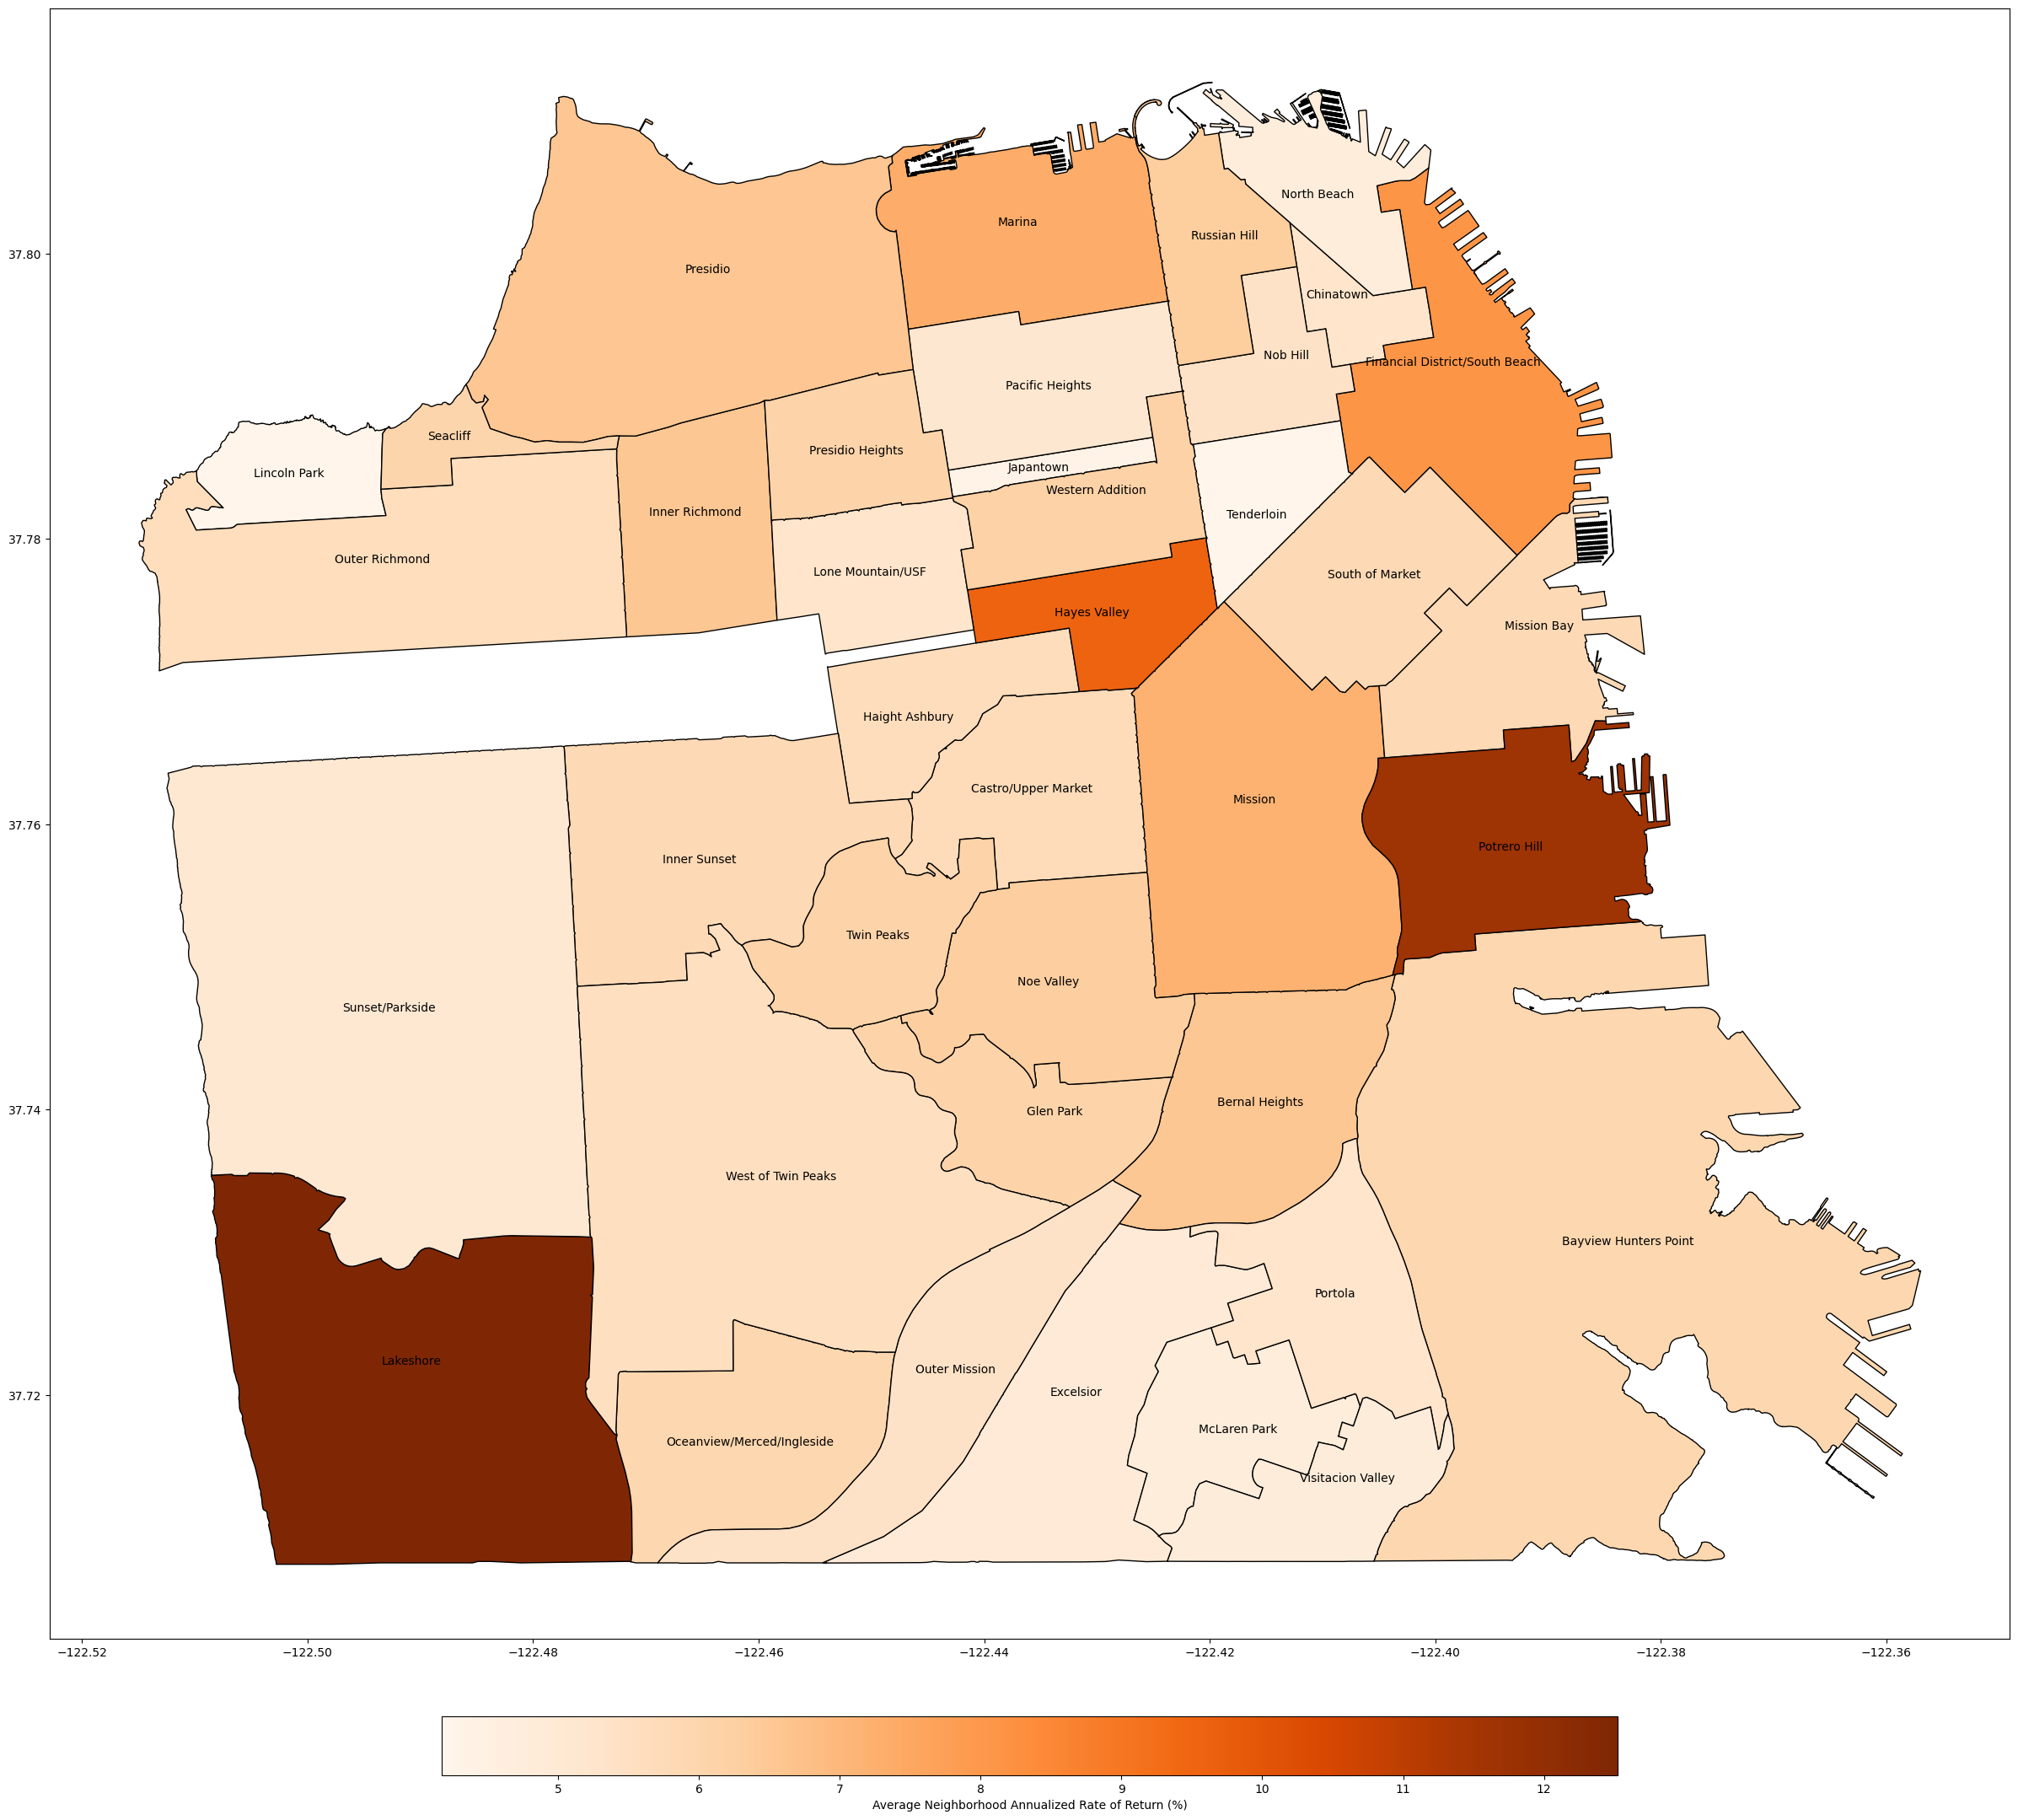

In [64]:
gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf['coords'] = [coords[0] for coords in gdf['coords']]
plt.rcParams['figure.figsize'] = [30,60]

fig, ax = plt.subplots(1,1)


gdf.plot(ax=ax, cmap='Oranges', edgecolor='black', column = 'Annualized Return', legend=True, legend_kwds={
    "label": "Average Neighborhood Annualized Rate of Return (%)",
    "orientation": "horizontal",
    "shrink": 0.6,  # optional, shrinks colorbar size
    "pad": 0.02     # optional, reduces padding
})

for idx, row in gdf.iterrows():
   plt.annotate(row['Analysis Neighborhood'], 
             xy=row['coords'], 
             ha='center', va='center',   # shorter aliases for alignment
             color='black', size=10)


## Stock Market Performance (S&P 500)

The following section shows the S&P 500 returns for the period of January 1, 2007 through July 30, 2024.

/var/folders/k0/hlz149vj4dx8_mt5pkd4tz600000gn/T/ipykernel_2661/4026734433.py:2: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


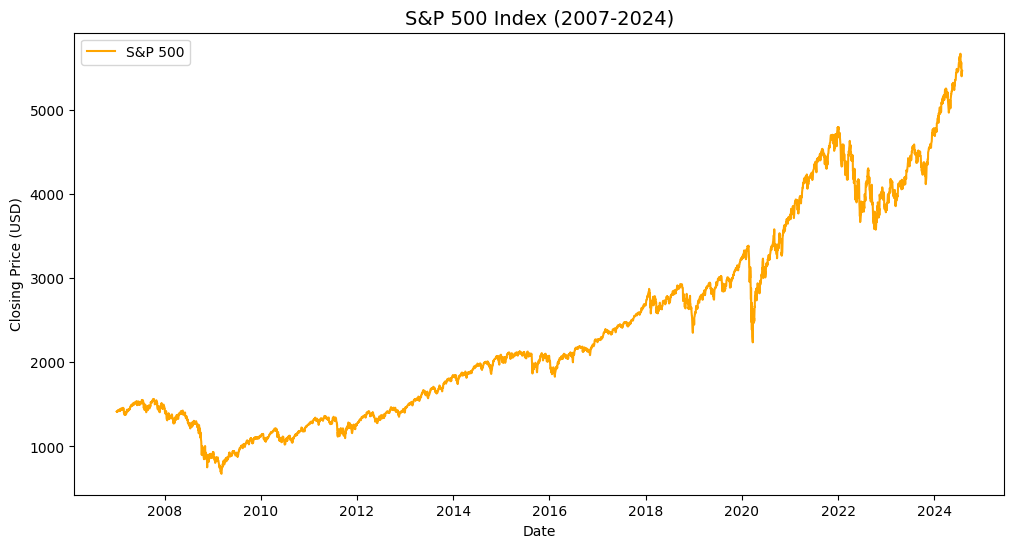

In [90]:
# Download S&P 500 data (ticker symbol for S&P 500 index is ^GSPC)
sp500 = yf.download("^GSPC", start="2007-01-01", end="2024-07-30")

# Plot closing price
plt.figure(figsize=(12,6))
plt.plot(sp500['Close'], label='S&P 500', color="orange")
plt.title("S&P 500 Index (2007-2024)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.show()

/var/folders/k0/hlz149vj4dx8_mt5pkd4tz600000gn/T/ipykernel_2661/712882215.py:3: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



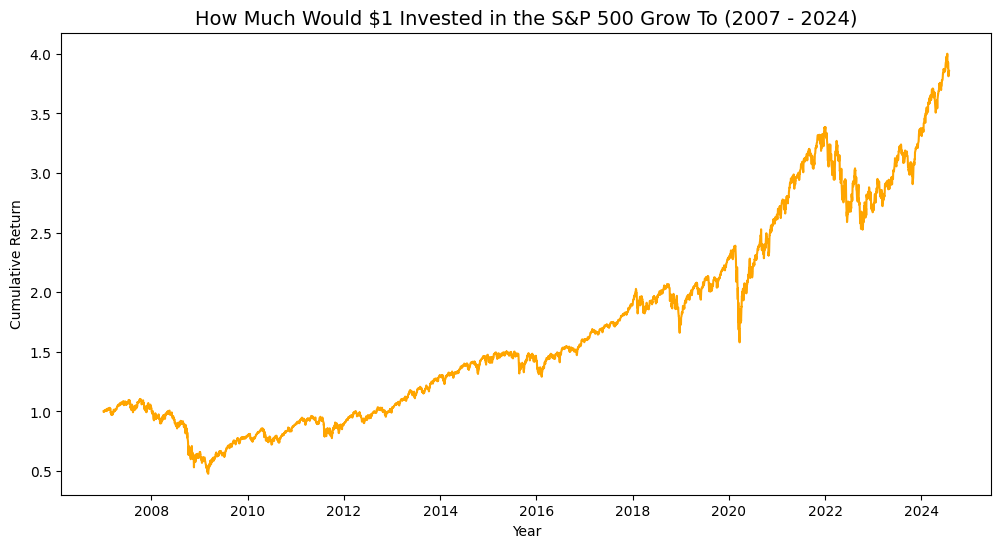

In [92]:
sp500['Daily Return'] = sp500['Close'].pct_change()
# Annual return = product of (1 + daily return) - 1
annual_returns = sp500['Daily Return'].resample('Y').apply(lambda r: (1 + r).prod() - 1)

# Convert index to just year
annual_returns.index = annual_returns.index.year

sp500['Cumulative Return'] = (1 + sp500['Daily Return']).cumprod()

plt.figure(figsize=(12,6))

# Cumulative return
plt.plot(sp500['Cumulative Return'], label='Cumulative Return ($1 invested)', color='orange')
plt.title("How Much Would $1 Invested in the S&P 500 Grow To (2007 - 2024)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Cumulative Return")

plt.show()

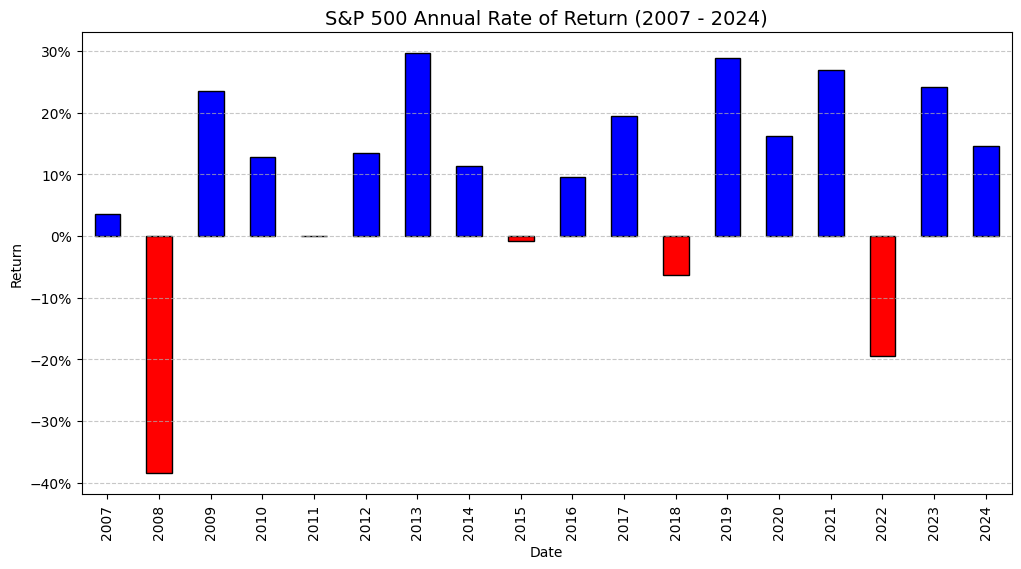

In [91]:
# Annual returns (bar chart, secondary plot)
colors = ['blue' if val >= 0 else 'red' for val in annual_returns]

# Plot
fig, ax = plt.subplots(figsize=(12,6))
annual_returns.plot(kind='bar', ax=ax, color=colors, edgecolor = 'black')

ax.set_title("S&P 500 Annual Rate of Return (2007 - 2024)", fontsize=14)
ax.set_ylabel("Return")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # show as percent
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()

While there could be significant fluctuations in the annual rate of return for SP500, investing in an index fund like SP500 for the long-run can be a great way to build wealth in comparison to owning a home in the San Francisco Bay Area.